# Structural Time Series Models with Tensorflow Probability

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts
import time

tf.enable_v2_behavior()

## Filtering & Smoothing

### 1-D Example

In [2]:
num_timesteps = 100
def build_ssm_1d():
    local_ssm = tfp.sts.LocalLinearTrendStateSpaceModel(
        num_timesteps=num_timesteps,
        level_scale=0.5,
        slope_scale=0.1,
        initial_state_prior=tfd.MultivariateNormalDiag(
            loc=[0., 0.],
            scale_diag=[1., 1.])
    )

    day_of_week_ssm = tfp.sts.SeasonalStateSpaceModel(
        num_timesteps=num_timesteps,
        num_seasons=7,
        drift_scale=0.1,
        initial_state_prior=tfd.MultivariateNormalDiag(
            loc=tf.zeros([7]),
            scale_diag=tf.ones([7]))
    )

    additive_ssm = tfp.sts.AdditiveStateSpaceModel(
        component_ssms=[local_ssm, day_of_week_ssm],
        observation_noise_scale=0.1
    )
    return additive_ssm



In [3]:
model=build_ssm_1d()
y = model.sample()


Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
Previously, `initial_step` would return the value passed to the constructor, even if that value was not `Tensor`-like. This behavior is now deprecated. In the future, it will always return a `Tensor`-like object.


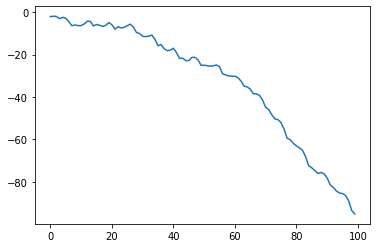

In [4]:
plt.plot(y)

### 2-D Example


In [5]:
ndims = 2
step_std = 0.1
noise_std = 0.1

def build_model(num_timesteps, scale_std, noise_std, ndims):
    model = tfd.LinearGaussianStateSpaceModel(
        num_timesteps=num_timesteps,
        transition_matrix=tf.linalg.LinearOperatorIdentity(ndims),
        transition_noise=tfd.MultivariateNormalDiag(
            scale_diag=step_std**2 * tf.ones([ndims])
        ),
        observation_matrix=tf.linalg.LinearOperatorIdentity(ndims),
        observation_noise=tfd.MultivariateNormalDiag(
            scale_diag=noise_std**2 * tf.ones([ndims])),
        initial_state_prior=tfd.MultivariateNormalDiag(
            scale_diag=tf.ones([ndims])
        )
    )
    
    return model

In [6]:
# generate observations
samples=2
trajectories=build_model(num_timesteps=20, scale_std=0.1, noise_std=0.1, ndims=2).sample(samples)

In [7]:
model = build_model(num_timesteps=20, scale_std=0.1, noise_std=0.1, ndims=2)

#### Filtering

In [8]:
log_likelihood, filtered_means, filtered_covs, predicted_means, predicted_covs,observed_means, observed_covs = model.forward_filter(trajectories)

#### Smoothing

In [9]:
smoothed_means, smoothed_covs = model.backward_smoothing_pass(filtered_means, filtered_covs, predicted_means, predicted_covs)

#### Posterior Simulation = Smoothing

### Plots

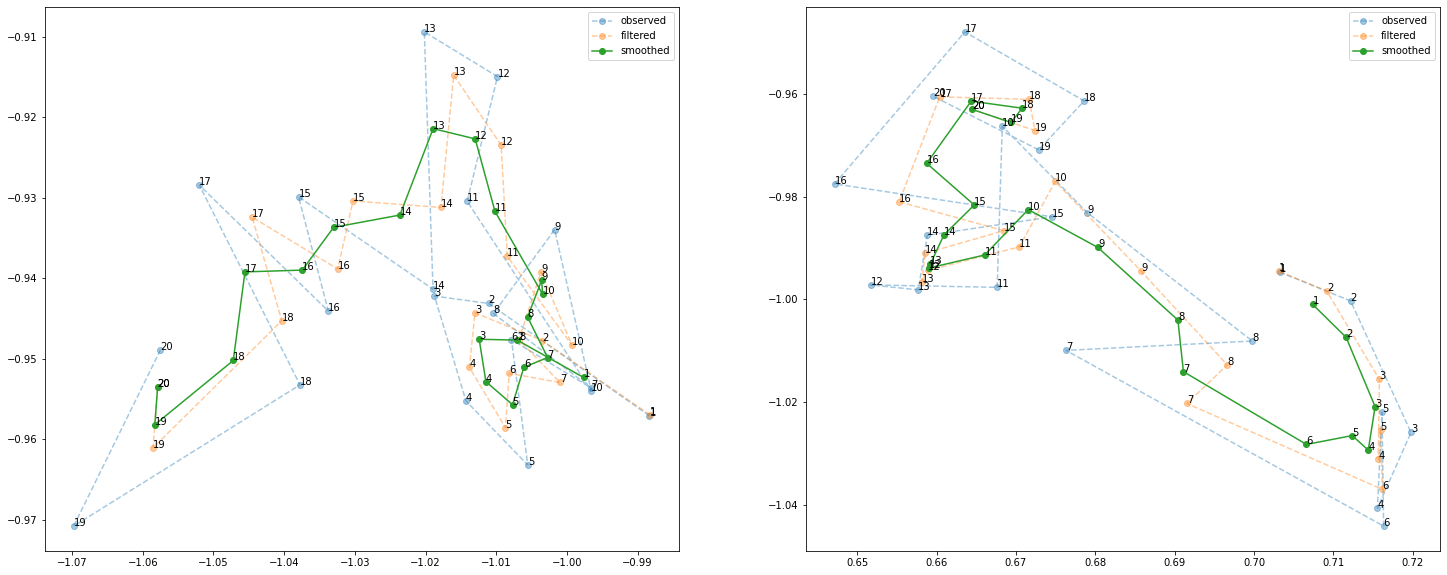

In [10]:
fig, ax = plt.subplots(1, samples, figsize=(25,10))
for i in range(samples):
    ax[i].plot(trajectories[i, :, 0], trajectories[i, :, 1], '--o',  alpha=0.4, label="observed")
    ax[i].plot(filtered_means[i, :, 0], filtered_means[i, :, 1], '--o', alpha=0.4, label="filtered")
    ax[i].plot(smoothed_means[i, :, 0], smoothed_means[i, :, 1], '-o',  alpha=1, label="smoothed")
    ax[i].legend()
    for j in range(trajectories.shape[1]):
        ax[i].text(trajectories[i, j, 0], trajectories[i, j, 1], str(j+1))
    for j in range(filtered_means.shape[1]):
        ax[i].text(filtered_means[i, j, 0], filtered_means[i, j, 1], str(j+1))
    for j in range(smoothed_means.shape[1]):
        ax[i].text(smoothed_means[i, j, 0], smoothed_means[i, j, 1], str(j+1))
    
    
    

## Introduction to Monte Carlo Methods

### Linear Model with homoscedastic error

In [195]:
# forward pass
def forward_pass(xs, num_replicas=1):
    k = xs.shape[0]
    
    beta = tfd.Normal(loc=tf.zeros(k), scale=1.).sample(num_replicas)
    sigma = tfd.Gamma(concentration=0., rate=1.).sample(num_replicas)
    
    mu = tf.linalg.matmul(beta[tf.newaxis, ...], xs)[-1,:]    
    y = tfd.Normal(loc=mu, scale=1.).sample()
    
    return y

In [199]:
k = 4
n = 100
num_replicas = 3

x = tfd.Uniform(-10, 10).sample((k, n))
x = tf.pad(x, [[1, 0], [0, 0]], constant_values=1)
y = forward_pass(xs=x, num_replicas=num_replicas)

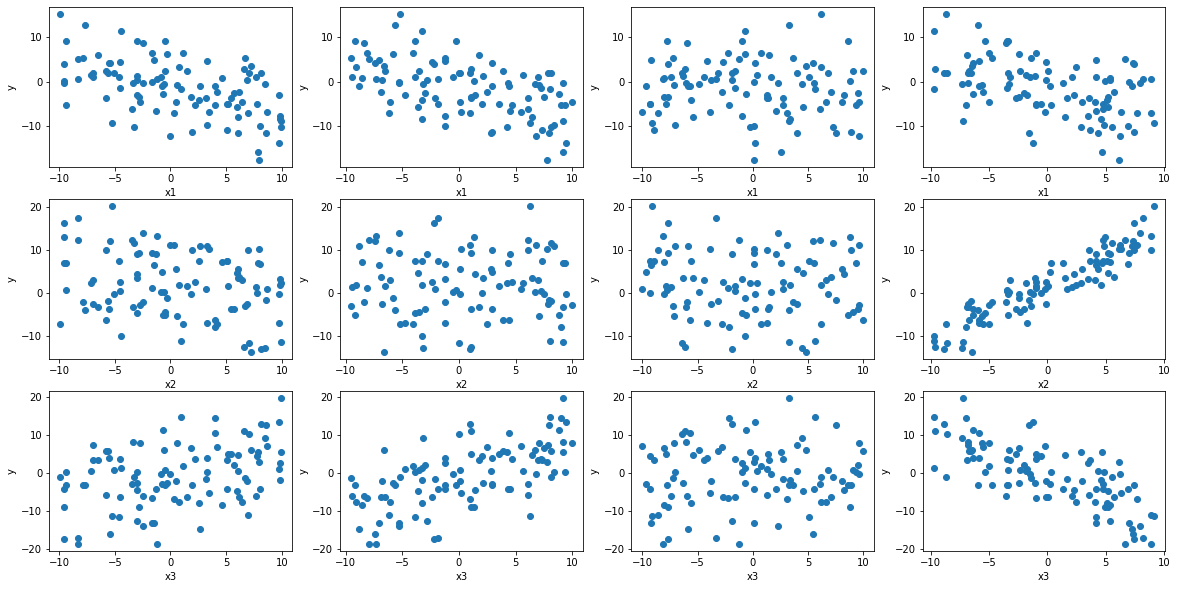

In [214]:
if num_replicas > 1:
    if k>= 2:
        fig, ax = plt.subplots(num_replicas, k,  figsize=(20,10))
        for i in range(num_replicas):
            for j in range(0, k):
                ax[i, j].plot(x[j+1, :], y[i, :], "o")
                ax[i, j].set_xlabel(f"x{i+1}")
                ax[i, j].set_ylabel("y")
                
    else:
        fig, ax = plt.subplots(1, num_replicas, figsize=(20,8))
        for i in range(num_replicas):
            for j in range(0, k):
                ax[i].plot(x[j, :], y[i, :], "o")
                ax[i].set_xlabel(f"x{i+1}")
                ax[i].set_ylabel("y")
else:
    if k>= 2:
        fig, ax = plt.subplots(1, k-1,  figsize=(20,5))
        for j in range(0, k):
            ax[j].plot(x[j+1, :], y[i, :], "o")
            ax[j].set_xlabel(f"x{j+1}")
            ax[j].set_ylabel("y")
                
    else:
        fig, ax = plt.subplots(1,1, figsize=(20,5))
        for j in range(0, k):
            ax.plot(x[j, :], y[0, :], "o")
            ax.set_xlabel(f"x{i+1}")
            ax.set_ylabel("y")

#### MCMC

In [231]:
# backward pass
def joint_log_prob(beta, xs, ys):
    k = xs.shape[0]
    
    # prior
    beta_rv = tfd.MultivariateNormalDiag(loc=tf.zeros(k), scale_diag=tf.ones(k))
    mu = tf.linalg.matmul(beta[tf.newaxis, ...], xs)[-1,:]
    y_rv = tfd.Normal(loc=mu, scale=1.)

    return beta_rv.log_prob(beta) +  tf.reduce_sum(y_rv.log_prob(ys), axis=-1)

In [232]:
x_obs = np.array(x)
y_obs = np.array(y[0, ]).ravel()

In [233]:
print(x_obs.shape)
print(y_obs.shape)

(5, 100)
(100,)


In [234]:
def unnormalized_posterior(beta):
    return joint_log_prob(beta, x_obs, y_obs)

#### Random Walk Metropolis Hastings

Default Proposal Distribution

In [392]:
# tuning the RandomWalkMetropolis by changing scale of the proposal
rw_kernel = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=unnormalized_posterior,
    #new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=1, name=None)
)

In [393]:
@tf.function
def run_chain(initial_state, num_results=2000, num_burnin=1000, num_chains=4):
    chains, kernel_results = tfp.mcmc.sample_chain(
        kernel=rw_kernel,
        num_results=num_results, 
        current_state=initial_state,
        num_burnin_steps=num_burnin,
        trace_fn=lambda cs, kr: kr,
        parallel_iterations=num_chains
    )
    return chains, kernel_results 

In [394]:
num_results = 2000
num_burnin = 1000
num_chains = 1
initial_state = tf.zeros(k+1)
#initial_state = tf.convert_to_tensor(np.array([-32, -0.1, 0.45, 0.45, -0.15]), dtype=tf.float32)


samples, kernel_results  = run_chain(initial_state=initial_state, num_results=num_results, num_burnin=num_burnin)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

Acceptance rate: 0.0005


Tuned Proposal Distribution

In [395]:
# tuning the RandomWalkMetropolis by changing scale of the proposal
rw_kernel = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=unnormalized_posterior,
    new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.01, name=None)
)

In [396]:
@tf.function
def run_chain(initial_state, num_results=2000, num_burnin=1000, num_chains=4):
    chains, kernel_results = tfp.mcmc.sample_chain(
        kernel=rw_kernel,
        num_results=num_results, 
        current_state=initial_state,
        num_burnin_steps=num_burnin,
        trace_fn=lambda cs, kr: kr,
        parallel_iterations=num_chains
    )
    return chains, kernel_results 

In [397]:
num_results = 2000
num_burnin = 1000
num_chains = 1
initial_state = tf.zeros(k+1)
#initial_state = tf.convert_to_tensor(np.array([-32, -0.1, 0.45, 0.45, -0.15]), dtype=tf.float32)


samples, kernel_results  = run_chain(initial_state=initial_state, num_results=num_results, num_burnin=num_burnin)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

Acceptance rate: 0.592


MCMC Estiamtes

In [398]:
beta_mcmc = tf.math.reduce_mean(samples, axis=0)
for i, estimate in enumerate(beta_mcmc):
    print(f"MCMC Estimate for beta_{i}: {estimate}")

MCMC Estimate for beta_0: -0.6666260957717896
MCMC Estimate for beta_1: -0.6114423871040344
MCMC Estimate for beta_2: -0.7576022148132324
MCMC Estimate for beta_3: -0.16101732850074768
MCMC Estimate for beta_4: -0.7150012254714966


OLS Estiamtes

In [391]:
beta_ols = tf.linalg.solve(tf.linalg.matmul(x_obs, x_obs, adjoint_b=True), tf.linalg.matmul(x_obs, y_obs[..., tf.newaxis]))
for i, estimate in enumerate(beta_ols):
    print(f"OLS Estimate for beta_{i}: {estimate[0]}")

OLS Estimate for beta_0: -0.7104771137237549
OLS Estimate for beta_1: -0.6117525100708008
OLS Estimate for beta_2: -0.7574634552001953
OLS Estimate for beta_3: -0.1624578982591629
OLS Estimate for beta_4: -0.714257001876831


#### HMC

untuned HMC

In [400]:
# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_posterior,
  step_size=np.float64(.1),
  num_leapfrog_steps=2)

In [401]:
# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=hmc_kernel,
        trace_fn=lambda current_state, kernel_results: kernel_results
    )

In [402]:
initial_state = tf.zeros(k + 1)
samples, kernel_results = run_chain(initial_state)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

Acceptance rate: 0.0


hand-tuned HMC

In [424]:
# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_posterior,
  step_size=np.float64(.01),
  num_leapfrog_steps=4)

In [425]:
# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=hmc_kernel,
        trace_fn=lambda current_state, kernel_results: kernel_results
    )

In [426]:
initial_state = tf.zeros(k + 1)
samples, kernel_results = run_chain(initial_state)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

Acceptance rate: 0.953


automatic tuned HMC

In [499]:
def trace_fn(_, pkr):
      return (
          pkr.inner_results.log_accept_ratio,
          pkr.inner_results.accepted_results.target_log_prob,
          pkr.inner_results.accepted_results.step_size)


# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain_hmc(initial_state, num_results=2000, num_burnin_steps=2000):
    
    # Create an HMC TransitionKernel
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior,
        step_size=np.float64(.01),
        num_leapfrog_steps=4)

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel = inner_kernel,
        num_adaptation_steps=int(0.8*num_burnin_steps),
        target_accept_prob=0.65,
        adaptation_rate=0.01
    )

    samples, (log_accept_ratio, target_log_prob, step_size) = tfp.mcmc.sample_chain(
        kernel=kernel,
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        trace_fn=trace_fn
    ) 
    return samples, log_accept_ratio, target_log_prob, step_size

In [496]:
initial_state = tf.zeros(k + 1)
samples, log_accept_ratio, target_log_prob, step_size = run_chain_hmc(initial_state)
print("Acceptance rate:", tf.reduce_mean(tf.math.minimum(tf.exp(log_accept_ratio), 1)).numpy())

Acceptance rate: 0.60947376


In [497]:
beta_mcmc = tf.math.reduce_mean(samples, axis=0)
for i, estimate in enumerate(beta_mcmc):
    print(f"MCMC Estimate for beta_{i}: {estimate}")

MCMC Estimate for beta_0: -0.7083783745765686
MCMC Estimate for beta_1: -0.613211452960968
MCMC Estimate for beta_2: -0.7565488815307617
MCMC Estimate for beta_3: -0.16330093145370483
MCMC Estimate for beta_4: -0.7150892019271851


In [498]:
beta_ols = tf.linalg.solve(tf.linalg.matmul(x_obs, x_obs, adjoint_b=True), tf.linalg.matmul(x_obs, y_obs[..., tf.newaxis]))
for i, estimate in enumerate(beta_ols):
    print(f"OLS Estimate for beta_{i}: {estimate[0]}")

OLS Estimate for beta_0: -0.7104771137237549
OLS Estimate for beta_1: -0.6117525100708008
OLS Estimate for beta_2: -0.7574634552001953
OLS Estimate for beta_3: -0.1624578982591629
OLS Estimate for beta_4: -0.714257001876831


### No-U-Turn-Sampler (NUTS)

In [508]:
def trace_fn(_, pkr):
      return (
          pkr.inner_results.log_accept_ratio,
          pkr.inner_results.accepted_results.target_log_prob,
          pkr.inner_results.accepted_results.step_size)


# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain_nuts(initial_state, num_results=2000, num_burnin_steps=2000):
    
    kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=unnormalized_posterior,
        step_size=np.float64(.01),
        max_tree_depth=10,
        max_energy_diff=1000.0,
        unrolled_leapfrog_steps=1,
        parallel_iterations=10,
        seed=None,
        name=None
    )


#    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
#        inner_kernel = inner_kernel,
#        num_adaptation_steps=int(0.8*num_burnin_steps),
#        target_accept_prob=0.65,
#        adaptation_rate=0.01
#    )

    samples, kernel_results = tfp.mcmc.sample_chain(
        kernel=kernel,
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        #trace_fn=trace_fn
    ) 
    return samples, kernel_results

In [509]:
initial_state = tf.zeros(k + 1)
samples, kernel_results = run_chain_nuts(initial_state)
print("Acceptance rate:", tf.reduce_mean(tf.math.minimum(tf.exp(log_accept_ratio), 1)).numpy())

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 0.60947376


In [510]:
beta_mcmc = tf.math.reduce_mean(samples, axis=0)
for i, estimate in enumerate(beta_mcmc):
    print(f"MCMC Estimate for beta_{i}: {estimate}")

MCMC Estimate for beta_0: -0.7007550597190857
MCMC Estimate for beta_1: -0.6118965744972229
MCMC Estimate for beta_2: -0.7568023800849915
MCMC Estimate for beta_3: -0.16241292655467987
MCMC Estimate for beta_4: -0.7136104106903076


In [511]:
beta_ols = tf.linalg.solve(tf.linalg.matmul(x_obs, x_obs, adjoint_b=True), tf.linalg.matmul(x_obs, y_obs[..., tf.newaxis]))
for i, estimate in enumerate(beta_ols):
    print(f"OLS Estimate for beta_{i}: {estimate[0]}")

OLS Estimate for beta_0: -0.7104771137237549
OLS Estimate for beta_1: -0.6117525100708008
OLS Estimate for beta_2: -0.7574634552001953
OLS Estimate for beta_3: -0.1624578982591629
OLS Estimate for beta_4: -0.714257001876831


### Gibbs Sampler

In [35]:
num_burnin

100

### Metropolis Hastings

### Random Walk Metropolis Hastings

### Hamiltonian Monte Carlo 

### No U-Turn Sampler

### MCMC for Structural Time Series

In [11]:
def sts_model():
    local_linear_trend = tfp.sts.LocalLinearTrend(
        level_scale_prior=None,
        slope_scale_prior=None,
        initial_level_prior=None,
        initial_slope_prior=None,
        observed_time_series=None,
        name=None,
    )
    
    day_of_week = tfp.sts.Seasonal(
        num_seasons=7,
        num_steps_per_season=1,
        allow_drift=True,
        drift_scale_prior=None,
        initial_effect_prior=None,
        constrain_mean_effect_to_zero=True,
        observed_time_series=None,
        name=None,
    )
    
    additive_model = tfp.sts.Sum(
        components=[local_linear_trend, day_of_week]
    )
    
    return additive_model

In [12]:
model = sts_model()

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [109]:
y, params = model.prior_sample(100)

In [112]:
for i, param in enumerate(model.parameters):
    print(f"{param.name}: {params[i]}")

observation_noise_scale: 0.03230465203523636
LocalLinearTrend/_level_scale: 3.469969306024723e-05
LocalLinearTrend/_slope_scale: 0.0017195811960846186
Seasonal/_drift_scale: 0.021265100687742233


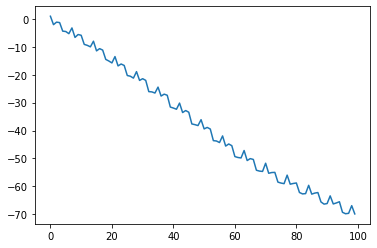

In [100]:
plt.plot(y)